# Import necessary libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

# Suppress the warnings (optional)
import warnings
warnings.filterwarnings('ignore')

In [3]:
base_path = "/kaggle/input/google-research-identify-contrails-reduce-global-warming"



In [8]:
import os

base_path = "/kaggle/input/google-research-identify-contrails-reduce-global-warming"
train_path = f"{base_path}/train"

# Pick the first sample ID folder
patch_id = os.listdir(train_path)[0]
print("Example patch folder:", patch_id)

# List what files are actually inside it
print("Files inside:", os.listdir(f"{train_path}/{patch_id}"))


Example patch folder: 1284412112608546821
Files inside: ['band_10.npy', 'band_14.npy', 'human_individual_masks.npy', 'band_15.npy', 'band_16.npy', 'band_08.npy', 'band_09.npy', 'band_13.npy', 'band_11.npy', 'human_pixel_masks.npy', 'band_12.npy']


### Data visualization

Example patch folder: 1284412112608546821
Stacked image shape: (256, 256, 9)
Mask shape: (256, 256)


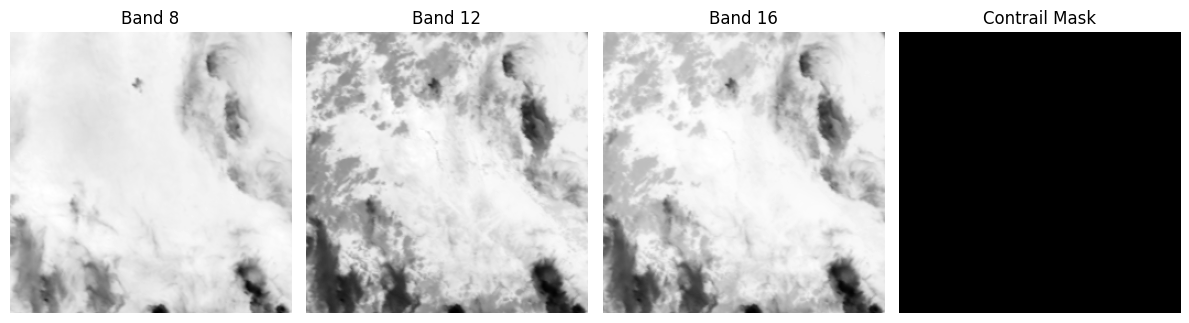

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt

base_path = "/kaggle/input/google-research-identify-contrails-reduce-global-warming"
train_path = f"{base_path}/train"

# Pick one patch
patch_id = os.listdir(train_path)[0]
print("Example patch folder:", patch_id)

bands = []
for b in range(8, 17):  # bands 8–16
    band = np.load(f"{train_path}/{patch_id}/band_{b:02d}.npy")
    
    # Ensure 2D by taking the first channel if it's multi-channel
    if band.ndim > 2:
        band = band[..., 0]
    bands.append(band)

# Stack into a (H, W, 9) array
image = np.stack(bands, axis=-1)
print("Stacked image shape:", image.shape)  # should be (256, 256, 9)

# Load the contrail mask
mask = np.load(f"{train_path}/{patch_id}/human_pixel_masks.npy")
if mask.ndim > 2:
    mask = mask[..., 0]
print("Mask shape:", mask.shape)

# Visualize 3 selected bands and mask
plt.figure(figsize=(12, 6))
band_map = {8: 0, 12: 4, 16: 8}  # band number -> stacked index

for idx, b in enumerate([8, 12, 16]):
    plt.subplot(1, 4, idx + 1)
    plt.imshow(image[..., band_map[b]], cmap='gray')
    plt.title(f"Band {b}")
    plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(mask, cmap='gray')
plt.title("Contrail Mask")
plt.axis("off")
plt.tight_layout()
plt.show()


### No Contrails in this image

## Data visualization with Contrails

Found patch with contrails: 7829917977180135058
Stacked image shape: (256, 256, 9)
Mask shape: (256, 256)


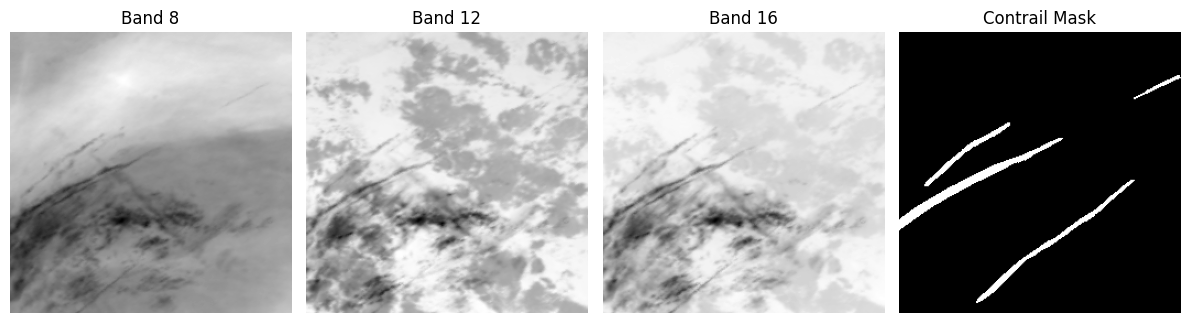

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt

base_path = "/kaggle/input/google-research-identify-contrails-reduce-global-warming"
train_path = f"{base_path}/train"

# Pick one patch
for patch_id in os.listdir(train_path):
    mask = np.load(f"{train_path}/{patch_id}/human_pixel_masks.npy")
    if mask.ndim > 2:
        mask = mask[..., 0]
    if mask.max() > 0:
        print("Found patch with contrails:", patch_id)
        break

bands = []
for b in range(8, 17):  # bands 8–16
    band = np.load(f"{train_path}/{patch_id}/band_{b:02d}.npy")
    
    # Ensure 2D by taking the first channel if it's multi-channel
    if band.ndim > 2:
        band = band[..., 0]
    bands.append(band)

# Stack into a (H, W, 9) array
image = np.stack(bands, axis=-1)
print("Stacked image shape:", image.shape)  # should be (256, 256, 9)

# Load the contrail mask
mask = np.load(f"{train_path}/{patch_id}/human_pixel_masks.npy")
if mask.ndim > 2:
    mask = mask[..., 0]
print("Mask shape:", mask.shape)

# Visualize 3 selected bands and mask
plt.figure(figsize=(12, 6))
band_map = {8: 0, 12: 4, 16: 8}  # band number -> stacked index

for idx, b in enumerate([8, 12, 16]):
    plt.subplot(1, 4, idx + 1)
    plt.imshow(image[..., band_map[b]], cmap='gray')
    plt.title(f"Band {b}")
    plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(mask, cmap='gray')
plt.title("Contrail Mask")
plt.axis("off")
plt.tight_layout()
plt.show()


### In this image we can see contrails appear